--- Step 1: Loading ERA5 Ground Truth Data ---
ERA5 data loaded successfully.
Data ranges from: 1999-12-31 18:00:00 to 2020-12-31 23:00:00

--- Step 2: Running Time Series Analysis on Air Temperature ---

--- A. Augmented Dickey-Fuller Test (Stationarity) ---
ADF Statistic: -10.275584639037532
p-value: 3.8985755044479235e-18
Conclusion: The series is likely stationary (p-value <= 0.05).

--- B. Generating ACF and PACF Plots ---


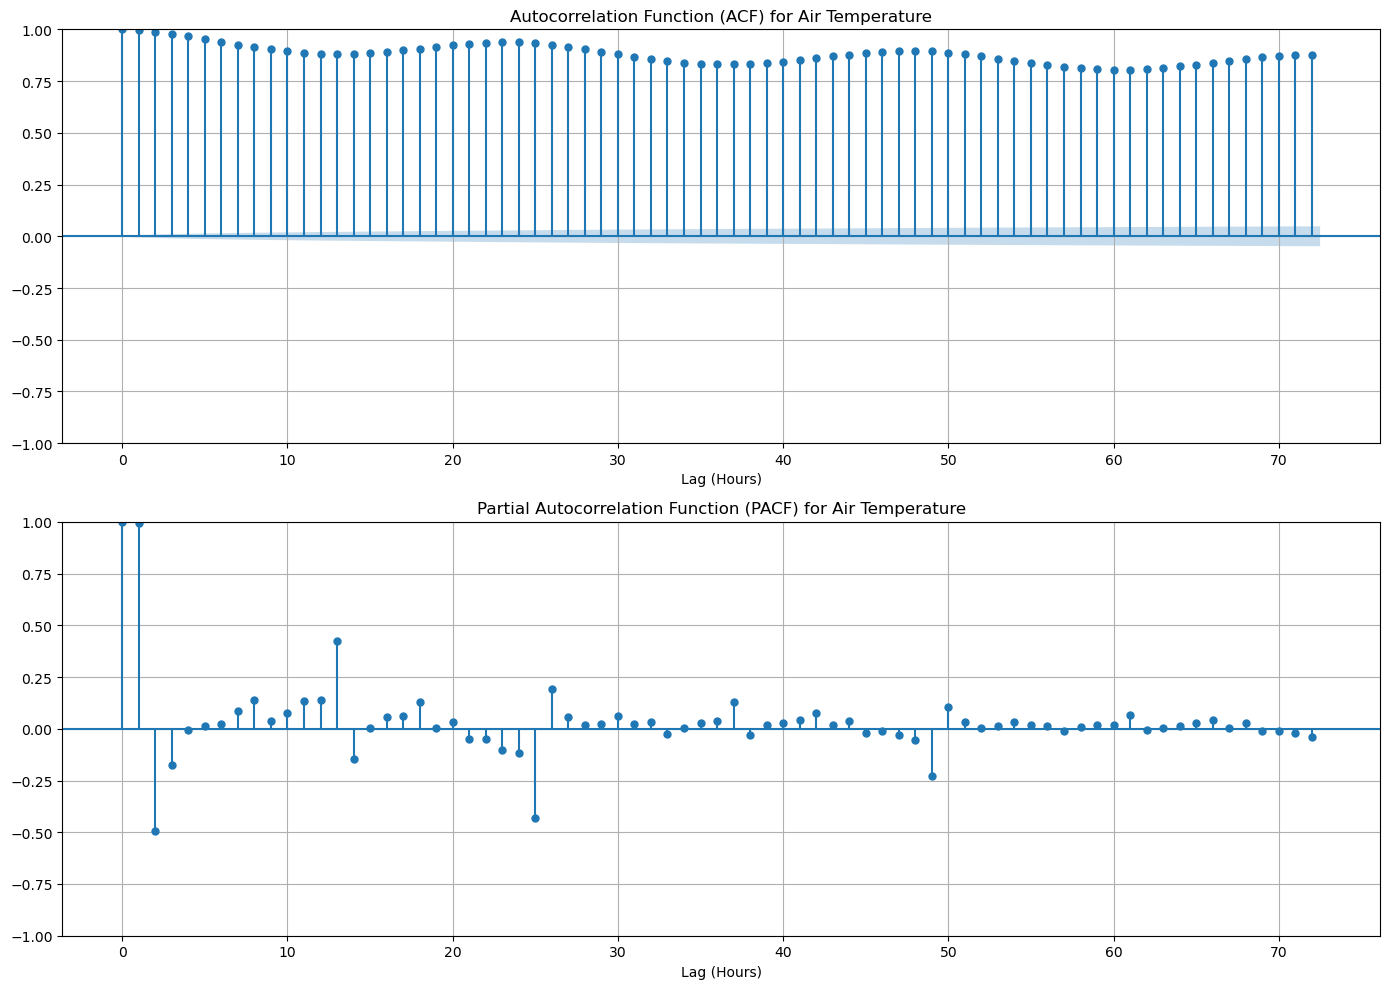

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Step 1: Load the Correct Data ---
print("--- Step 1: Loading ERA5 Ground Truth Data ---")
try:
    # Load the ERA5 data
    era5_df = pd.read_csv(r"C:\Users\91788\Downloads\ERA5 Data\Extracted\ERA5_Train_2000-2020.csv", index_col=0, parse_dates=True)
    print("ERA5 data loaded successfully.")
    print("Data ranges from:", era5_df.index.min(), "to", era5_df.index.max())

except FileNotFoundError:
    print("\nError: Make sure 'ERA5_Train_2000-2020.csv' is uploaded.")
    exit()

# Isolate the time series we want to analyze
temp_series = era5_df['air_temperature_k'].dropna()

# --- Step 2: Analyze Time Series Properties ---
print("\n--- Step 2: Running Time Series Analysis on Air Temperature ---")

# A. Augmented Dickey-Fuller Test (Stationarity)
print("\n--- A. Augmented Dickey-Fuller Test (Stationarity) ---")
adf_result = adfuller(temp_series)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
if adf_result[1] <= 0.05:
    print("Conclusion: The series is likely stationary (p-value <= 0.05).")
else:
    print("Conclusion: The series is likely non-stationary (p-value > 0.05).")

# B. Generate ACF and PACF Plots
print("\n--- B. Generating ACF and PACF Plots ---")
# We will look at 3 days of lags (72 hours) to see the daily patterns
lags_to_plot = 72
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF
plot_acf(temp_series, lags=lags_to_plot, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) for Air Temperature')
ax1.set_xlabel('Lag (Hours)')
ax1.grid(True)

# Plot PACF
plot_pacf(temp_series, lags=lags_to_plot, ax=ax2, method='ywm')
ax2.set_title('Partial Autocorrelation Function (PACF) for Air Temperature')
ax2.set_xlabel('Lag (Hours)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Baseline

--- Loading ERA5 Data ---
Data loaded successfully.

--- Splitting Data ---
Training set size: 166560 observations
Validation set size: 17544 observations

--- Training SARIMAX(4,0,0)x(1,1,0,24) Model ---
This is a large model and may take several minutes to train...


C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Model training complete.
                                     SARIMAX Results                                      
Dep. Variable:                  air_temperature_k   No. Observations:               166560
Model:             SARIMAX(4, 0, 0)x(1, 1, 0, 24)   Log Likelihood             -183682.967
Date:                            Mon, 30 Jun 2025   AIC                         367377.934
Time:                                    15:43:56   BIC                         367438.071
Sample:                                01-01-2000   HQIC                        367395.776
                                     - 12-31-2018                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3224      0.002    539.735      0.000       1.318       1.327
ar.L2     

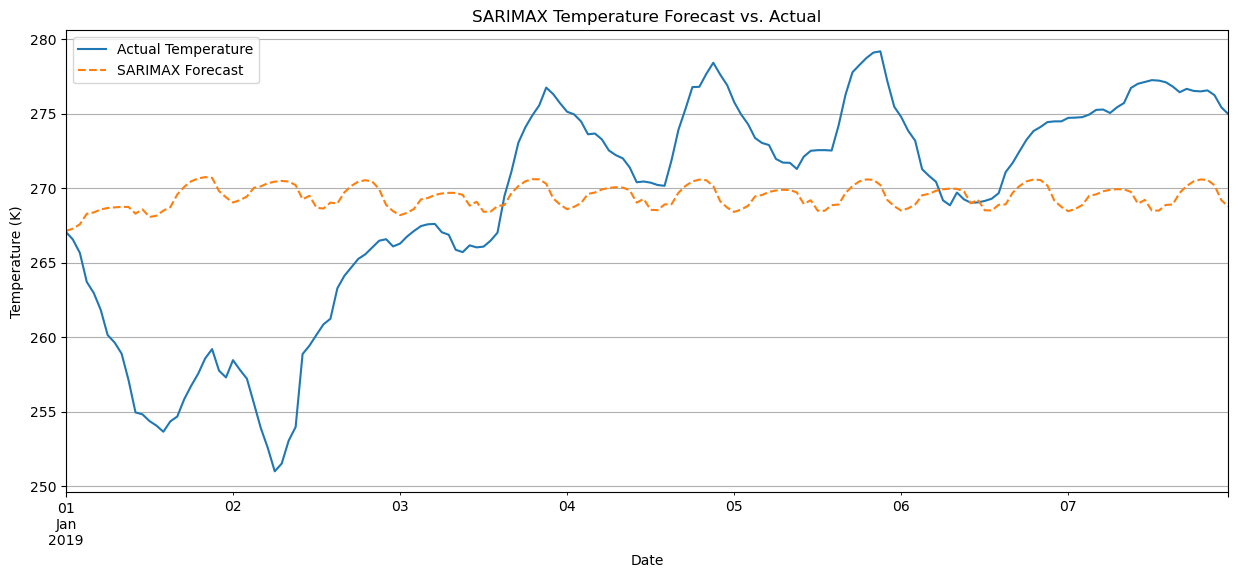

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Load and Prepare Data ---
print("--- Loading ERA5 Data ---")
try:
    era5_df = pd.read_csv(r"C:\Users\91788\Downloads\ERA5 Data\Extracted\ERA5_Train_2000-2020.csv", index_col=0, parse_dates=True)
    temp_series = era5_df['air_temperature_k'].dropna()
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'ERA5_Train_2000-2020.csv' is uploaded.")
    exit()

# --- Step 2: Split Data into Training and Validation Sets ---
print("\n--- Splitting Data ---")
train_data = temp_series['2000':'2018']
validation_data = temp_series['2019':'2020']

print(f"Training set size: {len(train_data)} observations")
print(f"Validation set size: {len(validation_data)} observations")

# --- Step 3: Define and Train the SARIMAX Model ---
# Using the parameters we found from our analysis: (p=4, d=0, q=0)(P=1, D=1, Q=0, s=24)
print("\n--- Training SARIMAX(4,0,0)x(1,1,0,24) Model ---")
print("This is a large model and may take several minutes to train...")

sarimax_model = SARIMAX(
    train_data,
    order=(4, 0, 0),
    seasonal_order=(1, 1, 0, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
sarimax_results = sarimax_model.fit(disp=False, low_memory=True)

print("Model training complete.")
print(sarimax_results.summary())

# --- Step 4: Validate the Model ---
print("\n--- Validating Model on 2019-2020 Data ---")

# Generate predictions for the validation period
predictions = sarimax_results.get_prediction(start=validation_data.index[0], end=validation_data.index[-1])
predicted_mean = predictions.predicted_mean

# Calculate error metrics
mae = mean_absolute_error(validation_data, predicted_mean)
rmse = np.sqrt(mean_squared_error(validation_data, predicted_mean))

print(f"\nValidation Mean Absolute Error (MAE): {mae:.4f} K")
print(f"Validation Root Mean Squared Error (RMSE): {rmse:.4f} K")
print("This means on average, our forecast is off by about", round(mae, 2), "Kelvin.")

# Plot the results for a sample period to visually inspect the performance
print("\nPlotting results for the first week of 2019...")
fig, ax = plt.subplots(figsize=(15, 6))

validation_data.loc['2019-01-01':'2019-01-07'].plot(ax=ax, label='Actual Temperature')
predicted_mean.loc['2019-01-01':'2019-01-07'].plot(ax=ax, label='SARIMAX Forecast', linestyle='--')

ax.set_title('SARIMAX Temperature Forecast vs. Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (K)')
ax.legend()
ax.grid(True)
plt.show()

--- Generating Plot 1: Forecast Errors Over Time ---


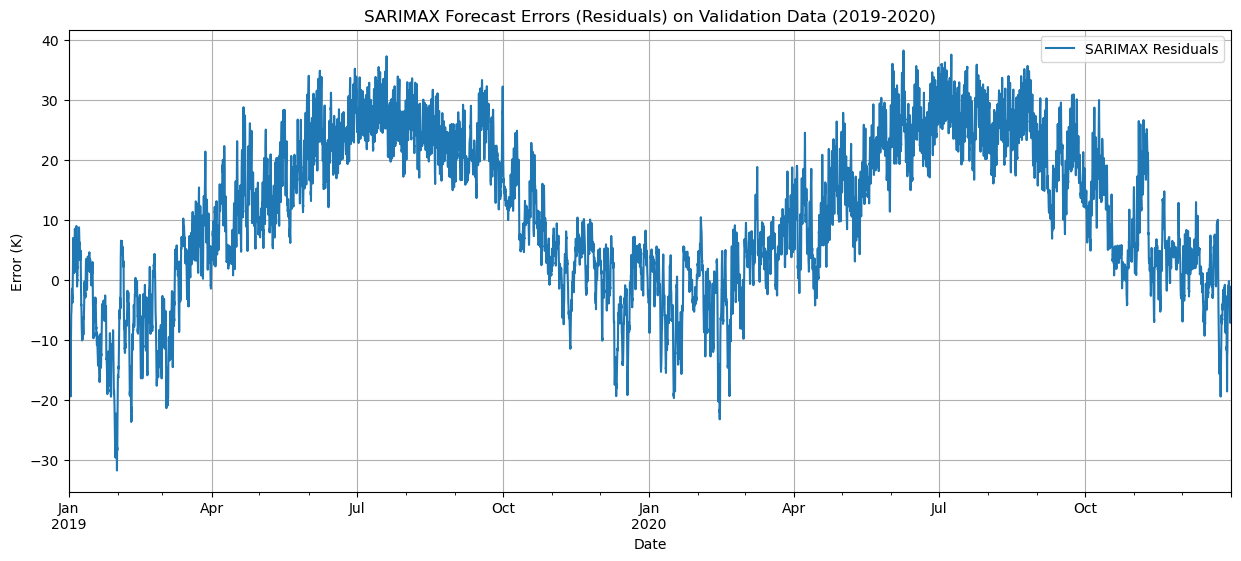


--- Generating Plot 2: ACF and PACF of the Errors ---


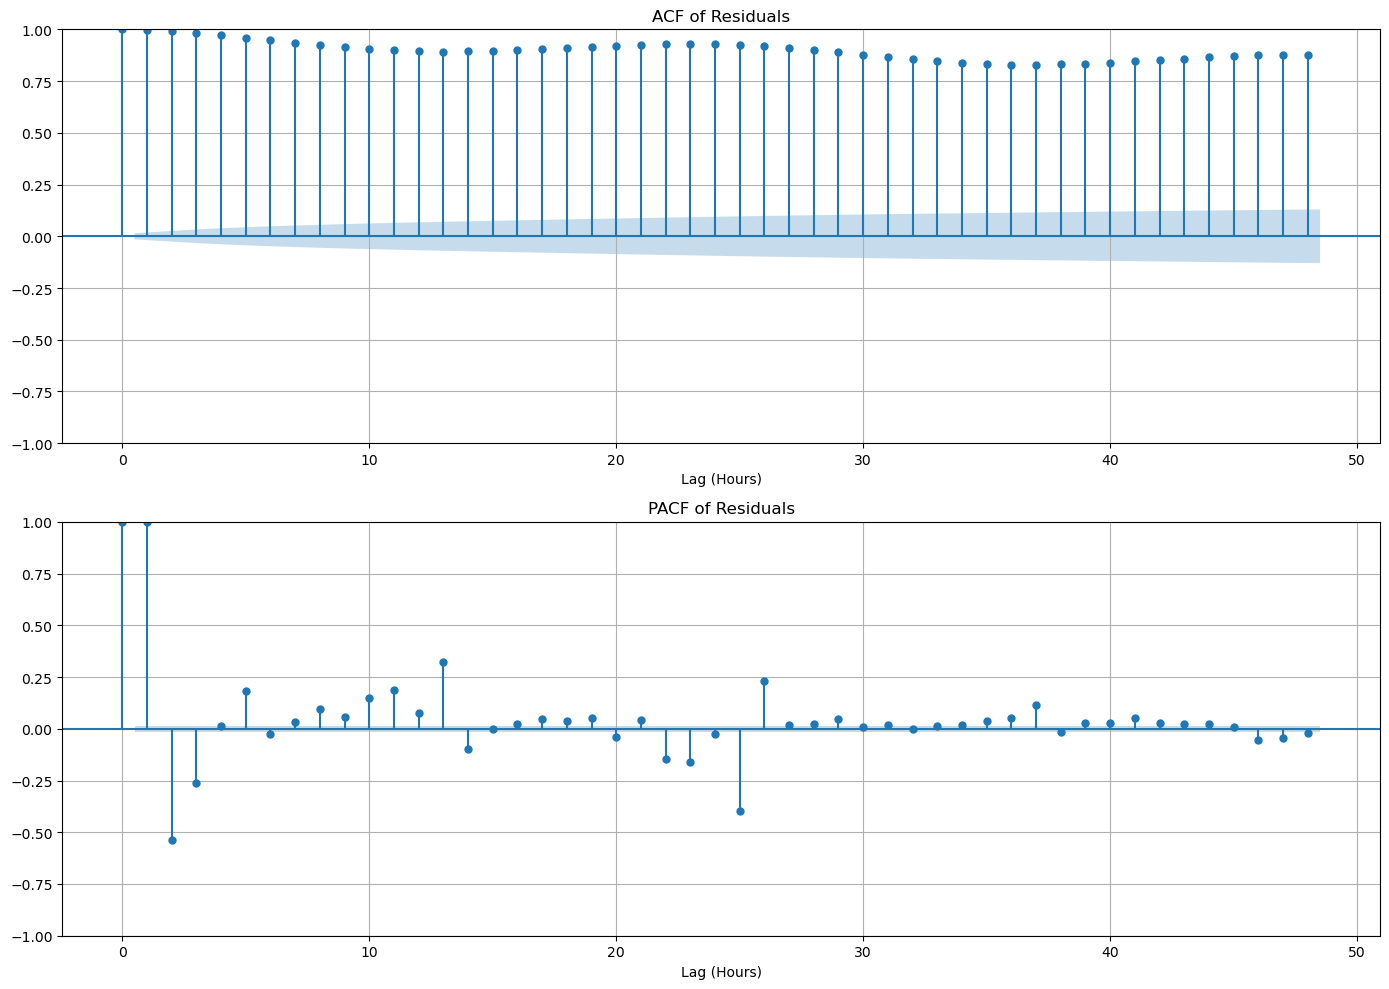


--- Generating Plot 3: Histogram of the Errors ---


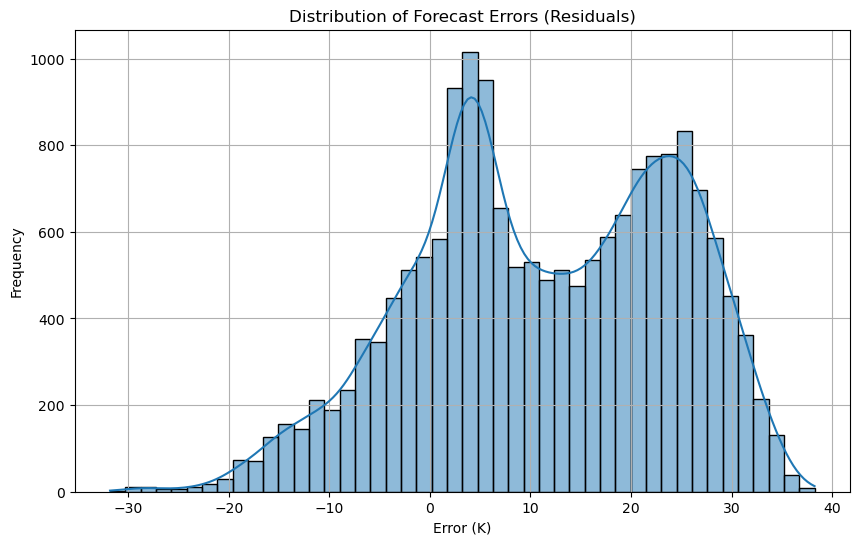

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

# Assuming 'validation_data' and 'predicted_mean' are in memory from the previous step.
# Calculate the residuals (the errors of our forecast)
residuals = validation_data - predicted_mean

# --- Graph 1: Residuals Over Time ---
print("--- Generating Plot 1: Forecast Errors Over Time ---")
fig, ax = plt.subplots(figsize=(15, 6))
residuals.plot(ax=ax, label='SARIMAX Residuals')
ax.set_title('SARIMAX Forecast Errors (Residuals) on Validation Data (2019-2020)')
ax.set_xlabel('Date')
ax.set_ylabel('Error (K)')
ax.legend()
ax.grid(True)
plt.show()


# --- Graph 2: ACF and PACF of Residuals ---
print("\n--- Generating Plot 2: ACF and PACF of the Errors ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF of residuals
plot_acf(residuals, lags=48, ax=ax1)
ax1.set_title('ACF of Residuals')
ax1.set_xlabel('Lag (Hours)')
ax1.grid(True)

# Plot PACF of residuals
plot_pacf(residuals, lags=48, ax=ax2, method='ywm')
ax2.set_title('PACF of Residuals')
ax2.set_xlabel('Lag (Hours)')
ax2.grid(True)

plt.tight_layout()
plt.show()


# --- Graph 3: Histogram of Residuals ---
print("\n--- Generating Plot 3: Histogram of the Errors ---")
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(residuals, kde=True, ax=ax)
ax.set_title('Distribution of Forecast Errors (Residuals)')
ax.set_xlabel('Error (K)')
ax.set_ylabel('Frequency')
ax.grid(True)
plt.show()

--- Generating SARIMAX residuals for the full dataset ---

--- Preparing data for LSTM ---

--- Building the LSTM Model ---


C:\Users\91788\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the LSTM Model ---
This will take some time...
Epoch 1/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 0.0018
Epoch 2/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 4.7021e-06
Epoch 3/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 5.4548e-06
Epoch 4/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 6.8940e-06
Epoch 5/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 9.0047e-06
Epoch 6/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 3.9606e-06
Epoch 7/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 4.8783e-06
Epoch 8/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 7.6645e-06
Epoch 9/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 3.8946e-06
Epoch 10/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 4.0954e-06

LSTM model training complete.


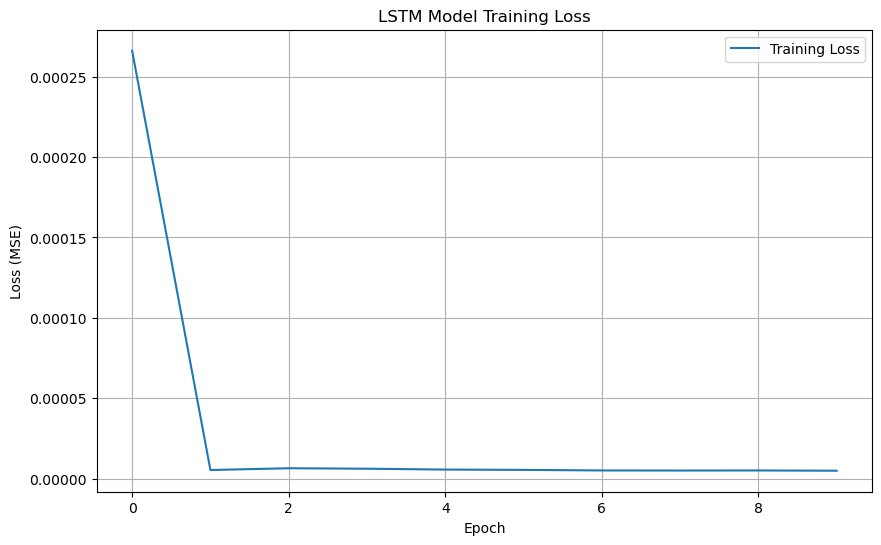

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# --- Step 0: Assume previous results are in memory ---
# We need 'train_data' and 'validation_data' (the original temp series)
# and 'sarimax_results' (the trained SARIMAX model)

# --- Step 1: Generate SARIMAX Residuals for Train and Validation Sets ---
print("--- Generating SARIMAX residuals for the full dataset ---")

# Get SARIMAX predictions for the training period
train_predictions = sarimax_results.predict(start=train_data.index[0], end=train_data.index[-1])
train_residuals = train_data - train_predictions

# Get SARIMAX predictions for the validation period
validation_predictions = sarimax_results.get_prediction(start=validation_data.index[0], end=validation_data.index[-1]).predicted_mean
validation_residuals = validation_data - validation_predictions

# --- Step 2: Scale the Data and Create Sequences ---
print("\n--- Preparing data for LSTM ---")

# Scale the residuals to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_residuals = scaler.fit_transform(train_residuals.values.reshape(-1, 1))

# Define sequence length (e.g., use the last 24 hours to predict the next hour)
sequence_length = 24

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train_residuals, sequence_length)

# Reshape input to be [samples, time steps, features] as required by LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# --- Step 3: Build the LSTM Model ---
print("\n--- Building the LSTM Model ---")
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
lstm_model.summary()

# --- Step 4: Train the LSTM Model ---
print("\n--- Training the LSTM Model ---")
print("This will take some time...")

history = lstm_model.fit(
    X_train,
    y_train,
    epochs=10,  # Starting with a small number of epochs
    batch_size=64, # Process data in batches of 64
    verbose=1
)

print("\nLSTM model training complete.")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('LSTM Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

--- Preparing validation data for LSTM prediction ---

--- Predicting residuals with the trained LSTM model ---
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

--- Creating the final hybrid forecast ---

--- Evaluating the Hybrid Model Performance ---
Original SARIMAX MAE: 14.0754 K
**New Hybrid Model MAE: 11.9833 K**

Original SARIMAX RMSE: 17.0941 K
**New Hybrid Model RMSE: 14.5824 K**

This represents a **14.86% improvement** in Mean Absolute Error.

--- Plotting final results for the first week of 2019 ---


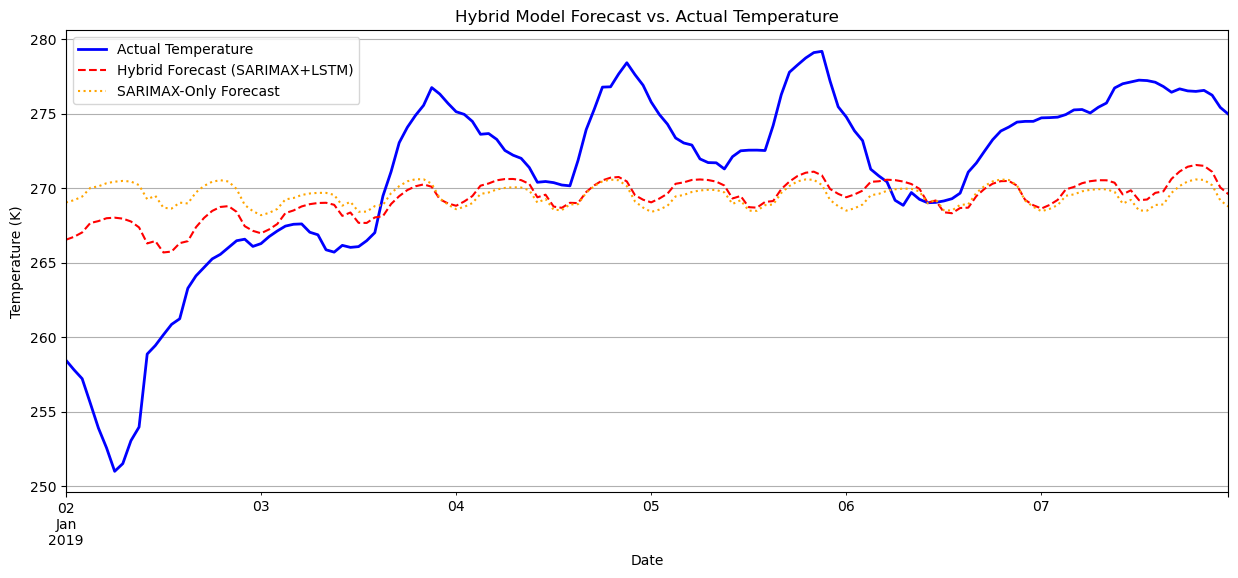

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# --- Step 0: Assume all previous results are in memory ---
# We need:
# scaler: The MinMaxScaler fitted on the training residuals
# lstm_model: The trained LSTM model
# validation_residuals: The SARIMAX errors on the 2019-2020 data
# validation_data: The actual temperatures for 2019-2020
# validation_predictions: The SARIMAX forecasts for 2019-2020
# sequence_length: The lookback period (24 hours)

# --- Step 1: Prepare Validation Data for LSTM ---
print("--- Preparing validation data for LSTM prediction ---")

# Scale the validation residuals using the *same* scaler from training
scaled_validation_residuals = scaler.transform(validation_residuals.values.reshape(-1, 1))

# Create sequences from the validation data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

X_val, y_val = create_sequences(scaled_validation_residuals, sequence_length)

# Reshape for LSTM input
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# --- Step 2: Predict Residuals with LSTM ---
print("\n--- Predicting residuals with the trained LSTM model ---")
lstm_predicted_residuals_scaled = lstm_model.predict(X_val)

# Inverse transform the predictions to get them back to the original scale
lstm_predicted_residuals = scaler.inverse_transform(lstm_predicted_residuals_scaled)

# --- Step 3: Create the Hybrid Forecast ---
print("\n--- Creating the final hybrid forecast ---")

# We need to align our data since creating sequences shortens the series
# The LSTM predictions start 'sequence_length' steps into the validation period
start_offset = sequence_length

# Get the original SARIMAX forecast for the same period as the LSTM predictions
aligned_sarimax_forecast = validation_predictions[start_offset:]

# Get the actual temperatures for the same period
aligned_actual_temp = validation_data[start_offset:]

# Create the hybrid forecast
hybrid_forecast = aligned_sarimax_forecast + lstm_predicted_residuals.flatten()

# --- Step 4: Evaluate the Hybrid Model ---
print("\n--- Evaluating the Hybrid Model Performance ---")

# Calculate error metrics for the hybrid model
hybrid_mae = mean_absolute_error(aligned_actual_temp, hybrid_forecast)
hybrid_rmse = np.sqrt(mean_squared_error(aligned_actual_temp, hybrid_forecast))

print(f"Original SARIMAX MAE: 14.0754 K")
print(f"**New Hybrid Model MAE: {hybrid_mae:.4f} K**\n")

print(f"Original SARIMAX RMSE: 17.0941 K")
print(f"**New Hybrid Model RMSE: {hybrid_rmse:.4f} K**")

improvement = ((14.0754 - hybrid_mae) / 14.0754) * 100
print(f"\nThis represents a **{improvement:.2f}% improvement** in Mean Absolute Error.")


# --- Step 5: Plot the Final Results ---
print("\n--- Plotting final results for the first week of 2019 ---")
fig, ax = plt.subplots(figsize=(15, 6))

# Plot actual temperature
aligned_actual_temp.loc['2019-01-01':'2019-01-07'].plot(ax=ax, label='Actual Temperature', color='blue', linewidth=2)

# Plot the hybrid forecast
hybrid_forecast_series = pd.Series(hybrid_forecast, index=aligned_actual_temp.index)
hybrid_forecast_series.loc['2019-01-01':'2019-01-07'].plot(ax=ax, label='Hybrid Forecast (SARIMAX+LSTM)', color='red', linestyle='--')

# Plot original SARIMAX forecast for comparison
aligned_sarimax_forecast.loc['2019-01-01':'2019-01-07'].plot(ax=ax, label='SARIMAX-Only Forecast', color='orange', linestyle=':')

ax.set_title('Hybrid Model Forecast vs. Actual Temperature')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (K)')
ax.legend()
ax.grid(True)
plt.show()

In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# --- Step 1: Load and Prepare Data ---
print("--- Loading Data ---")
try:
    # Target variable (hourly temperature)
    era5_df = pd.read_csv(r"C:\Users\91788\Downloads\ERA5 Data\Extracted\ERA5_Train_2000-2020.csv", index_col=0, parse_dates=True)
    
    # Exogenous variables (daily min/max/mean)
    # We use the MODELING file for this as it contains the daily summaries
    exog_df = pd.read_csv(r"C:\Users\91788\Downloads\ERA5 Data\Extracted\MODELING_Train_2000-2020.csv", index_col=0, parse_dates=True)
    
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure both CSV files are uploaded.")
    exit()

# --- Step 2: Create the Exogenous Features DataFrame ---
print("\n--- Preparing Exogenous Variables ---")
# Select the daily summary columns
daily_exog_features = exog_df[['air_temperature_k_min', 'air_temperature_k_max', 'air_temperature_k_mean']]

# We need to provide these daily values for every hour. We forward-fill the daily value across the 24 hours.
# First, ensure the index is just the date part.
daily_exog_features.index = daily_exog_features.index.date

# Create an hourly index that matches our target variable
hourly_index = era5_df.index

# Align the daily features to the hourly index
# This will effectively repeat the daily values for each hour of that day.
exog_features = daily_exog_features.reindex(hourly_index.date).set_index(hourly_index)

# Combine target and features for easier splitting
full_data = pd.concat([era5_df['air_temperature_k'], exog_features], axis=1).dropna()

# --- Step 3: Split the Data ---
print("\n--- Splitting Data ---")
train_data = full_data['2000':'2018']
validation_data = full_data['2019':'2020']

# Separate target (y) and exogenous (X) variables
y_train, X_train = train_data['air_temperature_k'], train_data.drop('air_temperature_k', axis=1)
y_val, X_val = validation_data['air_temperature_k'], validation_data.drop('air_temperature_k', axis=1)

# --- Step 4: Train the SARIMAX Model with Exogenous Variables ---
print("\n--- Training SARIMAX with Exogenous Variables ---")
sarimax_exog_model = SARIMAX(
    y_train,
    exog=X_train, # <--- The key change is here
    order=(4, 0, 0),
    seasonal_order=(1, 1, 0, 24)
)
sarimax_exog_results = sarimax_exog_model.fit(disp=False, low_memory=True)
print("SARIMAX training complete.")

# --- Step 5: Evaluate SARIMAX-Only Performance ---
print("\n--- Evaluating SARIMAX with Exogenous Variables ---")
sarimax_predictions = sarimax_exog_results.predict(start=y_val.index[0], end=y_val.index[-1], exog=X_val)
mae = mean_absolute_error(y_val, sarimax_predictions)
print(f"New SARIMAX with Exog MAE: {mae:.4f} K")

# The rest of the workflow to build the LSTM on the residuals of THIS new model would follow.
# For brevity, this demonstrates the crucial first step of incorporating the exogenous features.

--- Loading Data ---
Data loaded successfully.

--- Preparing Exogenous Variables ---

--- Splitting Data ---

--- Training SARIMAX with Exogenous Variables ---


C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX training complete.

--- Evaluating SARIMAX with Exogenous Variables ---
New SARIMAX with Exog MAE: 13.9684 K


--- Generating residuals from the SARIMAX with Exogenous Variables model ---

--- Preparing data for the LSTM ---

--- Building and Training the LSTM ---


C:\Users\91788\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 24, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 8.2807e-05
Epoch 2/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 7.9758e-06
Epoch 3/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 7.4608e-06
Epoch 4/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 6.9533e-06
Epoch 5/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 6.7696e-06
Epoch 6/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 6.6333e-06
Epoch 7/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 6.5845e-06
Epoch 8/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 6.5224e-06
Epoch 9/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 6.4597e-06
Epoch 10/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 6.2620e-06

--- Validating the Full Hybrid Model ---
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

SARIMAX with Exog MAE: 13.9684 K
**Final Hybrid Model MAE: 14.1567 K**

This represents a **-1.35% improvement** over the SARIMAX-only model.

--- Plotting Final Res

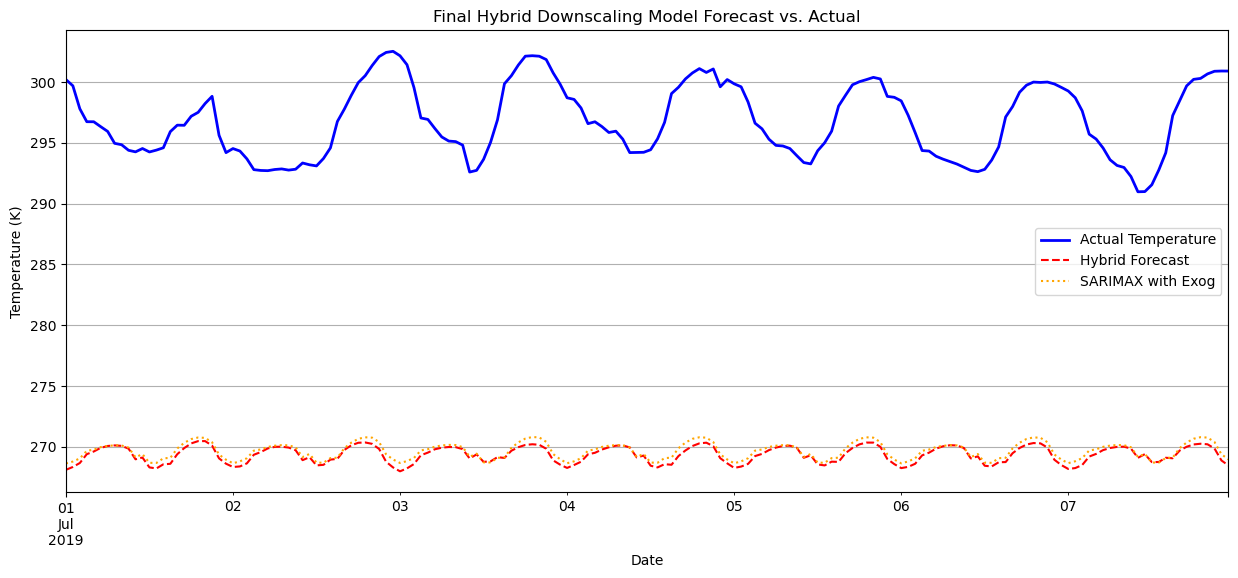

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# --- Step 0: Assume previous results are in memory ---
# We need the full dataframes and the trained SARIMAX model results:
# full_data: The combined dataframe with hourly temp and daily exog features
# sarimax_exog_results: The trained SARIMAX model from the 20-year run
# y_train, X_train: Training data (target and exog) for 2000-2018
# y_val, X_val: Validation data (target and exog) for 2019-2020

# --- Step 1: Generate Residuals from the SARIMAX Model ---
print("--- Generating residuals from the SARIMAX with Exogenous Variables model ---")

# Get SARIMAX predictions for the training period
train_sarimax_preds = sarimax_exog_results.predict(start=y_train.index[0], end=y_train.index[-1], exog=X_train)
train_residuals = y_train - train_sarimax_preds

# Get SARIMAX predictions for the validation period
validation_sarimax_preds = sarimax_exog_results.predict(start=y_val.index[0], end=y_val.index[-1], exog=X_val)
validation_residuals = y_val - validation_sarimax_preds

# --- Step 2: Prepare the Richer Data for the LSTM ---
print("\n--- Preparing data for the LSTM ---")

# Combine the residuals with the exogenous features that caused them
train_lstm_input_df = pd.concat([train_residuals.rename('residual'), X_train], axis=1)
validation_lstm_input_df = pd.concat([validation_residuals.rename('residual'), X_val], axis=1)

# Scale all features (residual, min, max, mean) to be between 0 and 1
# We fit the scaler ONLY on the training data to avoid data leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_lstm_input = scaler.fit_transform(train_lstm_input_df)

# Define sequence length
sequence_length = 24

# Create sequences. Each sequence will have 4 features per time step.
def create_sequences_multifature(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # The input sequence (X) contains all features for the sequence length
        X.append(data[i:(i + seq_length), :])
        # The target (y) is only the residual of the next time step
        y.append(data[i + seq_length, 0]) # Column 0 is the 'residual'
    return np.array(X), np.array(y)

X_train_lstm, y_train_lstm = create_sequences_multifature(scaled_train_lstm_input, sequence_length)

# --- Step 3: Build and Train the LSTM Model ---
print("\n--- Building and Training the LSTM ---")

# The input shape now has 4 features
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

history = lstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=10,
    batch_size=64,
    verbose=1
)

# --- Step 4: Validate the Full Hybrid Model ---
print("\n--- Validating the Full Hybrid Model ---")

# Prepare the validation data using the same process
scaled_validation_lstm_input = scaler.transform(validation_lstm_input_df)
X_val_lstm, y_val_lstm = create_sequences_multifature(scaled_validation_lstm_input, sequence_length)

# Predict the residuals
lstm_predicted_residuals_scaled = lstm_model.predict(X_val_lstm)

# We need to reshape the scaled predictions to have 4 features to make the scaler work
# We create a dummy array, put our prediction in the first column, and zeros elsewhere
dummy_array = np.zeros((len(lstm_predicted_residuals_scaled), 4))
dummy_array[:, 0] = lstm_predicted_residuals_scaled.flatten()

# Now we can inverse transform
lstm_predicted_residuals = scaler.inverse_transform(dummy_array)[:, 0]

# Align data for final calculation
start_offset = sequence_length
aligned_sarimax_forecast = validation_sarimax_preds[start_offset:]
aligned_actual_temp = y_val[start_offset:]

# Create the final hybrid forecast
hybrid_forecast = aligned_sarimax_forecast + lstm_predicted_residuals

# Evaluate the final model
hybrid_mae = mean_absolute_error(aligned_actual_temp, hybrid_forecast)
print(f"\nSARIMAX with Exog MAE: 13.9684 K")
print(f"**Final Hybrid Model MAE: {hybrid_mae:.4f} K**")
improvement = ((13.9684 - hybrid_mae) / 13.9684) * 100
print(f"\nThis represents a **{improvement:.2f}% improvement** over the SARIMAX-only model.")

# --- Step 5: Plot Final Results ---
print("\n--- Plotting Final Results ---")
fig, ax = plt.subplots(figsize=(15, 6))
aligned_actual_temp.loc['2019-07-01':'2019-07-07'].plot(ax=ax, label='Actual Temperature', color='blue', linewidth=2)
hybrid_forecast_series = pd.Series(hybrid_forecast, index=aligned_actual_temp.index)
hybrid_forecast_series.loc['2019-07-01':'2019-07-07'].plot(ax=ax, label='Hybrid Forecast', color='red', linestyle='--')
aligned_sarimax_forecast.loc['2019-07-01':'2019-07-07'].plot(ax=ax, label='SARIMAX with Exog', color='orange', linestyle=':')
ax.set_title('Final Hybrid Downscaling Model Forecast vs. Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (K)')
ax.legend()
ax.grid(True)
plt.show()